In [1]:
# Configuración inicial
from pathlib import Path
import pandas as pd
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from hydra import initialize, compose

# Configurar PROJECT_ROOT y agregar al PYTHONPATH
PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)

# Agregar el directorio raíz al PYTHONPATH
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"📍 PROJECT_ROOT: {PROJECT_ROOT}")
print(f"🐍 PYTHONPATH actualizado")

%matplotlib inline

📍 PROJECT_ROOT: c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive
🐍 PYTHONPATH actualizado


In [2]:
# Inicialización de Hydra
with initialize(version_base="1.2", config_path="../config"):
    cfg = compose(
        config_name="main",
        overrides=[
            f"paths.root={PROJECT_ROOT}",
            "data=default",
            "params=default",
            "process=default"
        ]
    )

print("\n⚙️ Configuración cargada:")
print(OmegaConf.to_yaml(cfg))


⚙️ Configuración cargada:
data:
  raw:
    _target_: src.config.DataConfig.RawConfig
    base_dir: ${paths.raw_dir}
    gdp_deflator:
      file: gdp_deflactor_usa/gdp_deflactor_usa.csv
      format: csv
      frequency: annual
    cpi:
      file: cpi/monthly_cpi.csv
      format: csv
      frequency: monthly
    gdp:
      file: gdp/anual_gdp_by_country.csv
      format: csv
      frequency: annual
    subnational_gdp_share:
      dir: subnational_gdp_share
      pattern: Indicador--Participacion*.csv
      format: csv
      frequency: annual
    subnational_income:
      file: subnational_income/subnational_income.xlsx
      format: excel
      frequency: annual
    exchange_rate:
      file: uy_exchange_rate/uy_exchange_rate.xlsx
      format: excel
      frequency: daily
    gasoline:
      file: gasoline/gasoline_sales.csv
      format: csv
      frequency: monthly
    diesel:
      file: diesel/diesel_sales.csv
      format: csv
      frequency: monthly
    shapefile:
      dir


💰 Procesando variables económicas...
▶ Iniciando process_gdp...
📊 Longitud de la serie: 64 elementos
✓ process_gdp completado en 0.01s


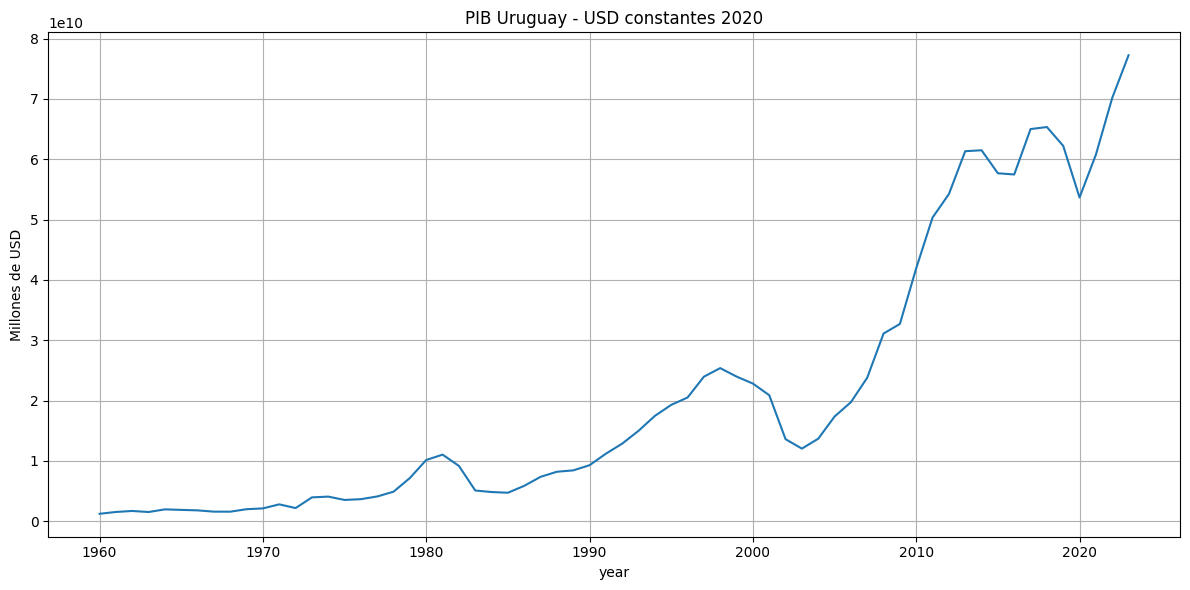

In [3]:
# Celda 3 - Procesamiento económico
from src.processors.economic import process_gdp_deflator, process_gdp

print("\n💰 Procesando variables económicas...")

# Procesamiento del deflactor del PIB
valor_2020, deflator_df = process_gdp_deflator(cfg)  # Pasamos cfg completo

# Lectura del PIB con parámetros específicos
gdp_path = os.path.join(cfg.paths.raw_dir, cfg.data.raw.gdp.file)
gdp_df = pd.read_csv(gdp_path, skiprows=4)  # Saltamos las primeras 4 filas de metadatos

# Procesamiento del PIB
gdp_df = process_gdp(
    input_gdp=gdp_df,  # Pasamos el DataFrame ya leído
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.gdp.file),
    cfg=cfg
)

# Visualización mejorada
plt.figure(figsize=(12, 6))
gdp_df.plot(title="PIB Uruguay - USD constantes 2020")
plt.grid(True)
plt.ylabel("Millones de USD")
plt.tight_layout()
plt.show()


📈 Procesando IPC...

💱 Procesando tipo de cambio...
Procesando tipos de cambio...


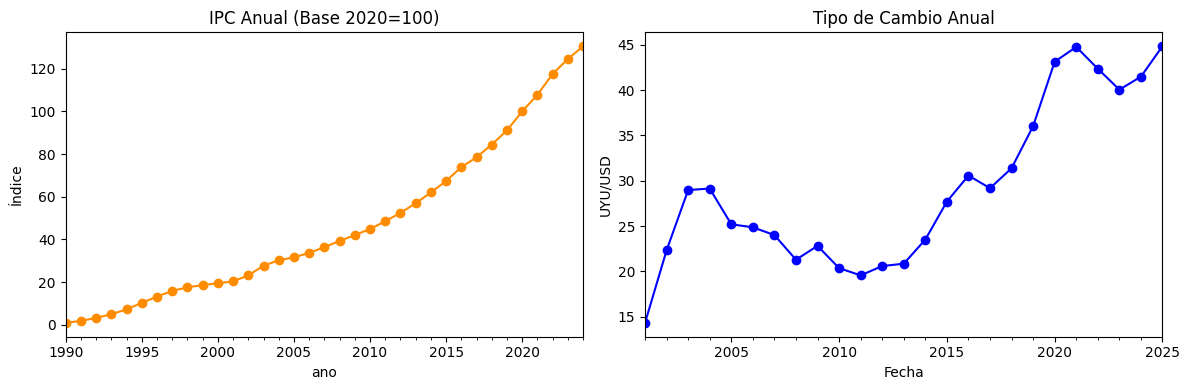

In [4]:
# Celda 4 - Procesamiento de precios y tipo de cambio
from src.processors.prices import process_cpi
from src.processors.exchange_rates import process_exchange_rate

print("\n📈 Procesando IPC...")
ipc_df = process_cpi(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.cpi.file),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.cpi.file),
    years_params=cfg.params.years
)

print("\n💱 Procesando tipo de cambio...")
tc_2020, tc_df = process_exchange_rate(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.exchange_rate.file),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.exchange_rate.file),
    years_params=cfg.params.years
)

# Visualizaciones
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ipc_df.plot(title="IPC Anual (Base 2020=100)", style='o-', color='darkorange')
plt.ylabel("Índice")

plt.subplot(1, 2, 2)
tc_df.plot(title="Tipo de Cambio Anual", style='o-', color='blue')
plt.ylabel("UYU/USD")

plt.tight_layout()
plt.show()

In [5]:
# Celda 5 - Procesamiento tributario
from src.processors.taxes import process_vehicle_tax

print("\n🚗 Procesando patentes vehiculares...")

patentes_df = process_vehicle_tax(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.subnational_income.file),
    ipc_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.cpi.file),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.vehicle_tax.file),
    years_params=cfg.params.years,
    exchange_rate=tc_2020  # Usamos el tipo de cambio 2020 calculado
)


🚗 Procesando patentes vehiculares...
Cargando datos de patentes...

Índice IPC después de conversión: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Años en df: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]



⛽ Procesando datos de combustibles...

Procesando datos de ventas de nafta...
Shape del DataFrame original: (260, 22)

Primeras filas del archivo original:
                   Name            Artigas Canelones balneario  \
0                  Area  Economic activity   Economic activity   
1              Currency                NaN                 NaN   
2  Inflation adjustment                NaN                 NaN   
3                  Unit       Cubic meters        Cubic meters   
4   Seasonal adjustment                NaN                 NaN   
5             Frequency                 ME                  ME   
6      Time series type               Flow                Flow   
7    Cumulative periods                  1                   1   
8                    Id   gasoline_sales_0    gasoline_sales_1   
9            2004-01-31            301.543            1780.971   

     Canelones resto        Cerro Largo            Colonia            Durazno  \
0  Economic activity  Economic acti

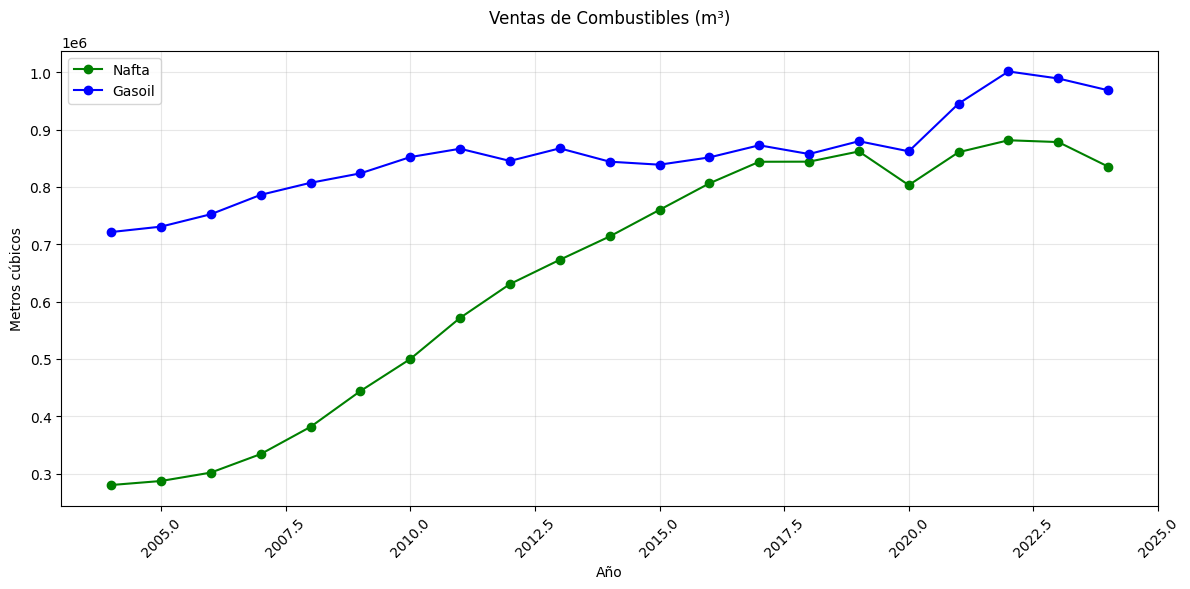


Estadísticas Nafta:
count        21.000000
mean     642513.380429
std      223741.856644
min      280093.954000
25%      444006.544000
50%      713661.470000
75%      843941.489000
max      881454.269000
Name: volumen, dtype: float64

Estadísticas Gasoil:
count    2.100000e+01
mean     8.554575e+05
std      7.553057e+04
min      7.213616e+05
25%      8.237134e+05
50%      8.521268e+05
75%      8.726899e+05
max      1.001462e+06
Name: volumen, dtype: float64


In [6]:
# Celda 6 - Procesamiento combustibles
from src.processors.fuels import process_gasoline, process_diesel

print("\n⛽ Procesando datos de combustibles...")

# Procesar nafta
nafta_df = process_gasoline(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.gasoline.file),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.gasoline.file),
    years_params=cfg.params.years,
    ipc_df=ipc_df,
    tc_2020=tc_2020
)

# Procesar gasoil
gasoil_df = process_diesel(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.diesel.file),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.diesel.file),
    years_params=cfg.params.years,
    ipc_df=ipc_df,
    tc_2020=tc_2020
)

# Obtener los DataFrames de las tuplas retornadas
nafta_df, _ = nafta_df  # Extraer solo el DataFrame
gasoil_df, _ = gasoil_df  # Extraer solo el DataFrame

# Crear un solo gráfico con ambas líneas
plt.figure(figsize=(12, 6))

# Graficar ambas series
plt.plot(nafta_df['year'], nafta_df['volumen'], 
         label='Nafta', color='green', marker='o')
plt.plot(gasoil_df['year'], gasoil_df['volumen'], 
         label='Gasoil', color='blue', marker='o')

# Configurar el gráfico
plt.title('Ventas de Combustibles (m³)', pad=20)
plt.xlabel('Año')
plt.ylabel('Metros cúbicos')
plt.grid(True, alpha=0.3)
plt.legend()

# Rotar etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir estadísticas básicas
print("\nEstadísticas Nafta:")
print(nafta_df['volumen'].describe())
print("\nEstadísticas Gasoil:")
print(gasoil_df['volumen'].describe())




🗺️ Procesando shapefile...
Cargando shapefile...
Usando shapefile: ine_depto.shp


c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive\src\processors\geo.py:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shp_output)
c:\Users\trico\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\trico\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'departamento' to 'departamen'
  ogr_write(
c:\Users\trico\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


<Figure size 1000x1200 with 0 Axes>

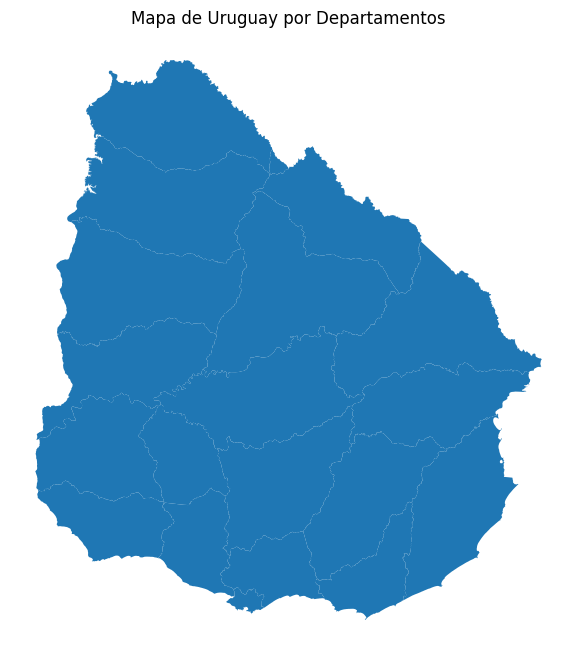

In [7]:
# %% [code]
# Celda 7 - Procesamiento geográfico
from src.processors.geo import process_shapefile

print("\n🗺️ Procesando shapefile...")

gdf = process_shapefile(
    input_dir=os.path.join(cfg.data.raw.base_dir, cfg.data.raw.shapefile.dir),
    output_dir=os.path.join(cfg.data.processed.base_dir, cfg.data.processed.shapefile.dir)
)

# Visualización mejorada
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax)
plt.title("Mapa de Uruguay por Departamentos")
plt.axis('off')
plt.show()


💰 Procesando participación en PIB departamental...

Procesando datos de participación en PIB departamental...
Encontrados 7 archivos para procesar
Procesando archivo: Indicador--Participacion-en-el-PIB-nacional-(-)222.csv
Archivo procesado exitosamente con codificación latin1
✓ Procesado: Indicador--Participacion-en-el-PIB-nacional-(-)222.csv
Procesando archivo: Indicador--Participacion-en-el-PIB-nacional-(-)28.csv
Archivo procesado exitosamente con codificación latin1
✓ Procesado: Indicador--Participacion-en-el-PIB-nacional-(-)28.csv
Procesando archivo: Indicador--Participacion-en-el-PIB-nacional-(-)335.csv
Archivo procesado exitosamente con codificación latin1
✓ Procesado: Indicador--Participacion-en-el-PIB-nacional-(-)335.csv
Procesando archivo: Indicador--Participacion-en-el-PIB-nacional-(-)50.csv
Archivo procesado exitosamente con codificación latin1
✓ Procesado: Indicador--Participacion-en-el-PIB-nacional-(-)50.csv
Procesando archivo: Indicador--Participacion-en-el-PIB-nacional-

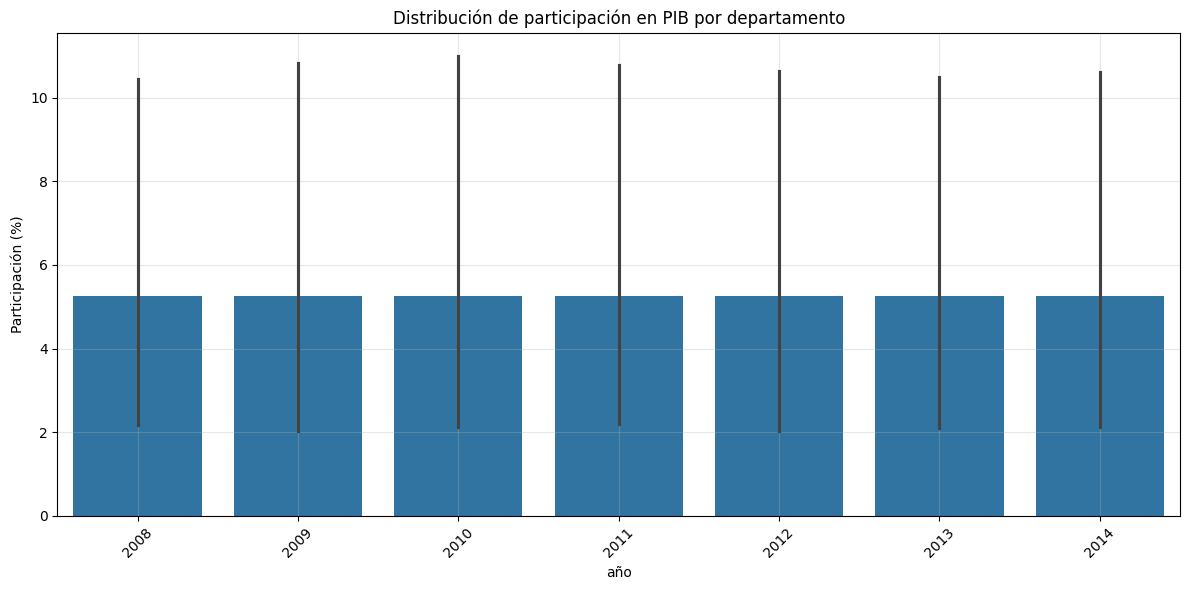


Estadísticas por año:
      count      mean        std       min       25%       50%       75%  \
año                                                                        
2008   19.0  5.263158  10.953350  0.781864  1.754622  2.124329  3.063429   
2009   19.0  5.263158  11.269838  0.769637  1.708980  2.021081  2.852350   
2010   19.0  5.263158  11.249185  0.723656  1.715528  2.188551  2.902246   
2011   19.0  5.263158  11.076789  0.786320  1.761906  2.181959  2.901665   
2012   19.0  5.263158  11.200205  0.764715  1.722384  2.115926  2.895282   
2013   19.0  5.263158  11.057923  0.782673  1.721746  2.162467  2.908300   
2014   19.0  5.263158  11.155388  0.735746  1.729870  2.171296  2.869361   

            max  
año              
2008  49.778965  
2009  51.072119  
2010  50.995525  
2011  50.288222  
2012  50.755719  
2013  50.100655  
2014  50.491522  


In [ ]:
# Celda 8 - Procesamiento participación PIB departamental
from src.processors.economic import process_gdp_share_raw

print("\n💰 Procesando participación en PIB departamental...")

# Procesar participación PIB
pib_share_df, metadata = process_gdp_share_raw(
    input_dir=os.path.join(cfg.paths.raw_dir, cfg.data.raw.subnational_gdp_share.dir),
    output_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.subnational_gdp_share.file),
    years_params=cfg.params.years
)

# Mostrar estadísticas
print("\nEstadísticas por año:")
print(pib_share_df.groupby('año')['participacion'].describe())